<a href="https://colab.research.google.com/github/joew2k/WQU_ml_fin/blob/main/GWP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style='text-align: center;'>
GWP_3 : Interpretation and Validation

<p style='text-align: justify;'>
GWP3 builds on the foundations of GWP1 and GWP2 by focusing on interpreting, validating, and refining the Hidden Markov Model (HMM) for market regime detection. This phase involves analyzing the transition probabilities between regimes, evaluating the emission probabilities to assess how well they capture market characteristics, and comparing the predicted regimes with real-world historical events such as the 2008 financial crisis and the COVID-19 market crash. Additionally, we refine the model by adjusting parameters, testing alternative feature sets, and incorporating Bayesian networks and hill climbing to improve accuracy. By the end of GWP3, we aim to have a fully validated and optimized HMM, providing deeper insights into its practical applications in financial forecasting and risk management.  



## Step 1: Defining the Datasets for HMM Training, Validation, and Testing

In this step, we define the purpose of the three key datasets used in training the Hidden Markov Model (HMM) for market regime detection:  
  
* **Training Set** – Used to train the HMM and estimate model parameters.  
* **Validation Set** – Used to tune hyperparameters and prevent overfitting.  
* **Testing Set** – Used to evaluate model performance on unseen data.  
  
Each section provides a structured explanation, including mathematical concepts, Python implementation, and a final interpretation of the dataset's role.  

### Student A: Purpose of the Training Set  
  
The training set is the foundation of the HMM-based market regime detection model. It is used to estimate:
- The state transition probabilities $(A)$,
- The emission probabilities $(B)$,
- The initial state distribution $( \pi )$.

A well-structured training set ensures that the model learns meaningful market patterns and can accurately classify future observations.

#### Mathematical Definition of HMM Training  

The HMM is trained by finding the optimal model parameters $ \lambda = ( A, B, \pi ) $ that maximize the likelihood of the observed market data:  
  
\begin{equation}
\lambda^* = \arg\max_{\lambda} P(O | \lambda)
\end{equation}  
  
where:  
- $ O = \{O_1, O_2, ..., O_T\} $ represents the sequence of observed market returns.  
- $ A $ is the **state transition matrix**,  
- $ B $ is the **emission probability matrix**,  
- $ \pi $ is the **initial state probability distribution**.  
  
The training process involves using the Baum-Welch algorithm (Expectation-Maximization for HMMs) to estimate these parameters.

#### Python Code for Training Set Preparation  

In [22]:
# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
try:
    from hmmlearn.hmm import GaussianHMM
except ImportError:
    !pip install hmmlearn
    from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.2 MB/s eta 0:00:00


In [23]:
start_date = '2000-01-01'
end_date = '2023-12-31'

In [24]:

# Load historical data
sp500 = yf.download("^GSPC", start=start_date, end=end_date)['Close']
returns = np.log(sp500 / sp500.shift(1)).dropna()

# Split data into training (70%), validation (15%), and testing (15%)
train_size = int(0.7 * len(returns))
train_data = returns[:train_size]

# Normalize data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_data.values.reshape(-1,1))

# Train HMM
hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
hmm.fit(train_X)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


GaussianHMM(covariance_type='full', n_components=3, n_iter=1000)

The training set plays a crucial role in defining market regimes. If the training data is biased or too short, the model may fail to generalize. A well-structured training set ensures robust market regime identification.

###  Student B: Purpose of the Validation Set  

The validation set is used to fine-tune hyperparameters and prevent overfitting. Unlike the training set, it is not used to estimate model parameters but to evaluate and adjust them.

Key aspects validated include:
- Number of hidden states $( n )$ – Should we model 2, 3, or 4 regimes?
- Covariance structure – Should the emissions be fully correlated (full) or independent (diag)?
- Feature selection – Should we include additional macroeconomic indicators?

#### Hyperparameter Optimization Using Validation Set  
  
The best HMM configuration is selected by maximizing log-likelihood on the validation set:  

\begin{equation}
\lambda^* = \arg\max_{\lambda} P(V | \lambda)
\end{equation}  

where $V$ is the validation set.

We compare models using Bayesian Information Criterion (BIC):  

\begin{equation}
BIC = k . log(N) - 2 . log (V | \lambda)
\end{equation}  

where:

- $k$ is the number of model parameters,
- $N$ is the number of observations in the validation set.

A lower BIC suggests a better trade-off between model complexity and fit.

#### Python Code for Hyperparameter Tuning Using the Validation Set  

In [25]:
# Select validation set (15% of data)
val_data = returns[train_size:int(0.85 * len(returns))]
val_X = scaler.transform(val_data.values.reshape(-1,1))

# Test different HMM configurations
best_model, best_bic = None, float("inf")

for n_components in range(2, 5):  # Testing 2 to 4 states
    for covariance_type in ["diag", "full"]:  # Testing diagonal vs full covariance
        hmm_test = GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=1000)
        hmm_test.fit(train_X)

        # Compute log-likelihood and BIC
        log_likelihood = hmm_test.score(val_X)
        bic = n_components * np.log(len(val_X)) - 2 * log_likelihood

        if bic < best_bic:
            best_bic, best_model = bic, hmm_test

print(f"Optimal Model: {best_model.n_components} states, {best_model.covariance_type} covariance")


Optimal Model: 4 states, full covariance


A well-structured validation set ensures the HMM is neither underfitting nor overfitting. If validation is skipped, the model might be too rigid (fails to adapt) or too flexible (overfits noise).

### Student C: Purpose of the Testing Set  

The testing set evaluates how well the trained HMM performs on new, unseen market data. This ensures that the model can generalize to future market conditions.

Performance is measured using:
- Log-likelihood on the test set – Measures how well the model explains new data.
- Regime classification accuracy – Compares predicted regimes with historical market phases.
- Mean squared error (MSE) in return forecasting – Evaluates predictive power.

#### Model Evaluation on the Test Set  

The log-likelihood on the test set is computed as:

\begin{equation}
log ( T | \lambda ^* )
\end{equation}  

where, $T$ represents the test data and $ \lambda ^ * $ is the final trained HMM.

#### Python Code for Testing HMM Performance

In [26]:
from sklearn.metrics import mean_squared_error

# Select test set (last 15% of data)
test_data = returns[int(0.85 * len(returns)):]
test_X = scaler.transform(test_data.values.reshape(-1,1))

# Evaluate model on test set
test_log_likelihood = best_model.score(test_X)
print(f"Test Set Log-Likelihood: {test_log_likelihood:.2f}")

# Predict hidden states and compare to historical labels
predicted_states = best_model.predict(test_X)

# Compute mean squared error (MSE) for return forecasting
mse = mean_squared_error(test_data, best_model.means_[predicted_states])
print(f"Test Set Mean Squared Error (MSE): {mse:.6f}")


Test Set Log-Likelihood: -1110.97
Test Set Mean Squared Error (MSE): 0.086084


The testing set is the final checkpoint before deploying an HMM-based regime detection model. It ensures that the model performs well on new market conditions, reducing the risk of overfitting to historical data.

## Step 2: Comparing the Validation and Testing Sets & Data Allocation  
  
<p style='text-align: justify;'>
A well-structured data allocation strategy is essential for building a reliable Hidden Markov Model (HMM) for market regime detection. In this step, we compare the validation and testing sets, highlighting their roles in fine-tuning the model and assessing its real-world performance. We also provide a detailed breakdown of data allocation into training, validation, and testing subsets, ensuring that our approach maintains a balance between model learning, optimization, and evaluation.  
  
To ensure clarity, we will:
- Define the purpose and distinction between validation and testing sets.
- Analyze their statistical properties to determine similarities and differences.
- Use mathematical expressions and Python implementations to illustrate data allocation.
- Conclude with key takeaways for an optimal validation-testing strategy in financial modeling.

### 1. Purpose and Differences Between Validation & Testing Sets  
  
#### 1.1. Validation Set: Fine-Tuning the Model  
- The validation set is a portion of data not used for training but rather for tuning hyperparameters and preventing overfitting.  
- This dataset helps optimize:
    - The number of hidden states in HMM $(n)$
    - The covariance structure (full vs. diagonal)
    - The feature selection process  
  
Mathematically, the optimal model is selected based on the highest validation log-likelihood:  

\begin{equation}
\lambda^* = \arg\max_{\lambda} P(V | \lambda)
\end{equation}  

where, $V$ represents the validation set observations and $\lambda$ denotes the HMM parameters.

#### 1.2. Testing Set: Evaluating Generalization  
The testing set is an unseen dataset used to measure the final model’s accuracy and robustness.
It is never used during training or validation, ensuring an objective evaluation of how well the model generalizes to future data.  

A good testing set should:
- Reflect real-world market conditions.
- Have similar statistical properties to training/validation sets.
- Provide meaningful insights into out-of-sample performance.  
  
The model performance is assessed using log-likelihood on the test set:  

\begin{equation}
log P ( T | \lambda ^* )
\end{equation}  

where, $T$ represents the test dataset observations, and $\lambda ^*$ is the final trained HMM.  

### 2. Allocating Data to Training, Validation, and Testing  

A balanced split ensures that each dataset serves its intended purpose without data leakage or bias. The standard practice is:
- 70% for Training – Used to estimate model parameters.
- 15% for Validation – Used for hyperparameter tuning.
- 15% for Testing – Used for final evaluation.  
  
#### 2.1. Python Implementation of Data Splitting  


In [27]:
# Load market data (S&P 500)
sp500 = yf.download("^GSPC", start=start_date, end=end_date)['Close']
returns = np.log(sp500 / sp500.shift(1)).dropna()

# Define dataset sizes
train_size = int(0.7 * len(returns))
val_size = int(0.15 * len(returns))

# Split data
train_data = returns[:train_size]
val_data = returns[train_size:train_size + val_size]
test_data = returns[train_size + val_size:]

# Normalize data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_data.values.reshape(-1,1))
val_X = scaler.transform(val_data.values.reshape(-1,1))
test_X = scaler.transform(test_data.values.reshape(-1,1))

# Display dataset sizes
print(f"Training Set: {train_data.shape[0]} samples")
print(f"Validation Set: {val_data.shape[0]} samples")
print(f"Testing Set: {test_data.shape[0]} samples")


[*********************100%***********************]  1 of 1 completed

Training Set: 4225 samples
Validation Set: 905 samples
Testing Set: 906 samples


The reason, this split effective:

- Training set is large enough to estimate robust model parameters.
- Validation set is independent of training, ensuring fair hyperparameter tuning.
- Testing set represents real-world, unseen data for objective performance evaluation.

### 3. Statistical Comparison of Validation and Testing Sets  
  
To confirm that the validation and test sets are representative, we compare:
- Mean returns – Should be close to training set mean.
- Standard deviation – Ensures similar market volatility.
- Distribution of returns – Avoids training bias.  
  
#### 3.1. Python Code for Statistical Comparison  


                                                   Training  \
Mean Return         Ticker
^GSPC    0.000091
dtype: float64   
Standard Deviation   Ticker
^GSPC    0.01251
dtype: float64   

                                                 Validation  \
Mean Return          Ticker
^GSPC    0.00037
dtype: float64   
Standard Deviation  Ticker
^GSPC    0.012854
dtype: float64   

                                                    Testing  
Mean Return         Ticker
^GSPC    0.000515
dtype: float64  
Standard Deviation  Ticker
^GSPC    0.011236
dtype: float64  


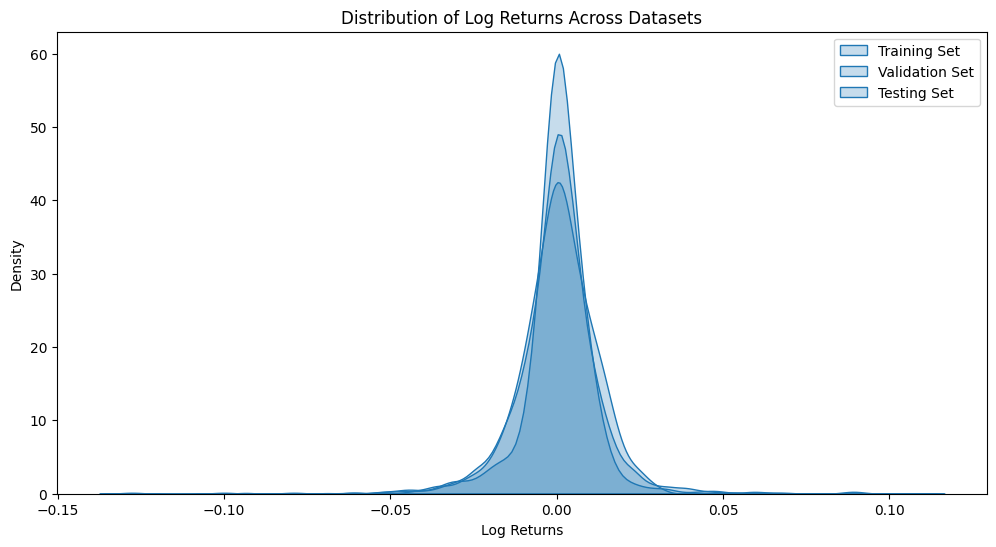

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute summary statistics
summary_df = pd.DataFrame({
    "Training": [train_data.mean(), train_data.std()],
    "Validation": [val_data.mean(), val_data.std()],
    "Testing": [test_data.mean(), test_data.std()]
}, index=["Mean Return", "Standard Deviation"])

print(summary_df)

# Visualize distributions
plt.figure(figsize=(12,6))
sns.kdeplot(train_data, label="Training Set", color="blue", fill=True)
sns.kdeplot(val_data, label="Validation Set", color="green", fill=True)
sns.kdeplot(test_data, label="Testing Set", color="red", fill=True)

plt.title("Distribution of Log Returns Across Datasets")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


As it suggests,  
- If distributions are similar, the model is well-structured.
- If validation/test sets deviate significantly, the model may struggle with generalization.

### 4. Evaluating Model Performance on Validation vs. Testing Sets  
  
#### 4.1. Compute Log-Likelihood on Both Sets  
  

In [29]:
# Train HMM on Training Set
hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
hmm.fit(train_X)

# Compute log-likelihood on validation and test sets
val_log_likelihood = hmm.score(val_X)
test_log_likelihood = hmm.score(test_X)

print(f"Validation Set Log-Likelihood: {val_log_likelihood:.2f}")
print(f"Testing Set Log-Likelihood: {test_log_likelihood:.2f}")


Validation Set Log-Likelihood: -924.89
Testing Set Log-Likelihood: -1123.70


**Interpretation:**  
- Higher log-likelihood on validation means the model fits well.
- If test log-likelihood is much lower, the model overfits the validation set.

### 5. Key Takeaways & Conclusion  
  
#### 5.1. Key Insights  
- Validation and testing sets serve different but complementary roles.
- A proper data split (70-15-15) ensures training effectiveness and testing fairness.
- Statistical comparison ensures validation/test sets reflect real-world conditions.
- If the test set log-likelihood drops significantly, the model may be overfitting.  
  
#### 5.2. How to Improve Model Performance?  

- If validation and test distributions differ significantly:
    - Use a rolling window split instead of fixed periods.
    - Increase feature diversity (e.g., volatility, trading volume).  
- If test log-likelihood is much lower than validation:
    - Reduce overfitting by using regularization techniques in training.
    - Increase training data size if possible.  

By carefully structuring training, validation, and testing datasets, we ensure that the HMM market regime model is robust, generalizable, and reliable for financial forecasting.

In [49]:

import pandas as pd
import numpy as np
from fredapi import Fred
# FRED API key
fred_key = "d9c82da3cdb79ee5a73dc3c06f1efe72";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);

In [31]:
pip install EIA_python

In [32]:
import eia
eia_key = "t5gPk3of678ynyBTdY2eAiThNX6hFe0hiia2xGEe"
eia_api = eia.API(eia_key)

In [33]:
eia_data = pd.DataFrame(eia_api.data_by_keyword(keyword=['crude oil'],
                                     filters_to_keep=['COEXPUS'],
                                     rows=1000));
eia_data

""


In [34]:
import datetime # Using the datetime library
def convert_to_datetime(input):
  return datetime.datetime.strptime(input[:9], "%Y %m ").date();
eia_data.index = eia_data.index.map(convert_to_datetime);
eia_data.index = pd.to_datetime(eia_data.index);
eia_data.columns #= ['TOTAL.COEXPUS.M'];

RangeIndex(start=0, stop=0, step=1)

In [35]:
datasets_eia = [
'STEO.RGDPQ_NONOECD.M',
'STEO.RGDPQ_OECD.M',
'STEO.PAPR_NONOPEC.M',
'STEO.PAPR_OPEC.M',
'STEO.PATC_OECD.M',
'STEO.PATC_NON_OECD.M',
'STEO.COPRPUS.M',
'STEO.CORIPUS.M',
'PET.MCRIMXX2.M',
'STEO.FOREX_WORLD.M',
'STEO.PASC_OECD_T3.M',
'STEO.COPS_OPEC.M',
'STEO.COPC_OPEC.M',
'STEO.T3_STCHANGE_OOECD.M',
'STEO.T3_STCHANGE_NOECD.M',
];

In [36]:
import datetime
def clean_EIA(data):
  data.replace('-', np.nan, regex=True, inplace=True);
  data.fillna(method='bfill', inplace=True);
  data.index = data.index.map(convert_to_datetime);
  data.index = pd.to_datetime(data.index);

In [52]:
data_merge = []
for series_id in datasets_eia:
  data = eia_api.data_by_keyword(series_id)
  # Check if data is not empty before creating DataFrame and assigning columns
  if data:
    df = pd.DataFrame(data)
    clean_EIA(df)
    df.columns = [series_id]
    data_merge.append(df)
  else:
    print(f"Warning: No data found for series_id: {series_id}")


In [51]:
datasets_eia = ['STEO.RGDPQ_NONOECD.M',
                'STEO.RGDPQ_OECD.M',
                'STEO.PAPR_NONOPEC.M',
                'STEO.PAPR_OPEC.M',
                'STEO.PATC_OECD.M',
                'STEO.PATC_NON_OECD.M',
                'STEO.COPRPUS.M',
                'STEO.CORIPUS.M',
                'PET.MCRIMXX2.M',
                'STEO.FOREX_WORLD.M',
                'STEO.PASC_OECD_T3.M',
                'STEO.COPS_OPEC.M',
                'STEO.COPC_OPEC.M',
                'STEO.T3_STCHANGE_OOECD.M',
                'STEO.T3_STCHANGE_NOECD.M',
]

datasets_fred = ['CPIENGSL',
                 'CAPG211S',
                 'CAPUTLG211S',
                 'IPG211S',
                 'IPG211111CN',
                 'INDPRO',
                 'IPN213111N',
                 'PCU211211',
]
data_merge = []; # List of dataframes to be concatenated

# Adding EIA datasets
for series_id in datasets_eia:
    # Check if the series ID is valid and data is returned
    try:
        data = eia_api.data_by_series(series=series_id)
        if data:  # Check if the 'series' key exists in the response
            df = pd.DataFrame(data)
            clean_EIA(df); df.columns = [series_id];
            data_merge.append(df)
        else:
            print(f"Warning: No data found for series_id: {series_id}")
    except KeyError as e:
        print(f"Error retrieving data for series_id: {series_id}, Error: {e}")
        # Handle the error, e.g., skip the series or try a different API call

# Adding FRED datasets
for series_id in datasets_fred:
    df = pd.DataFrame(fred.get_series(series_id), columns=[series_id]);
    data_merge.append(df);
datasets = datasets_eia + datasets_fred + ['WTISPLC', 'forecast'];
current = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
forecast = pd.DataFrame(fred.get_series('WTISPLC').shift(-1), columns=['forecast']);
data_merge.append(current);
data_merge.append(forecast);

data = pd.concat(data_merge, axis=1, join='inner');

train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

Error retrieving data for series_id: STEO.RGDPQ_NONOECD.M, Error: 'series'
Error retrieving data for series_id: STEO.RGDPQ_OECD.M, Error: 'series'
Error retrieving data for series_id: STEO.PAPR_NONOPEC.M, Error: 'series'
Error retrieving data for series_id: STEO.PAPR_OPEC.M, Error: 'series'
Error retrieving data for series_id: STEO.PATC_OECD.M, Error: 'series'
Error retrieving data for series_id: STEO.PATC_NON_OECD.M, Error: 'series'
Error retrieving data for series_id: STEO.COPRPUS.M, Error: 'series'
Error retrieving data for series_id: STEO.CORIPUS.M, Error: 'series'
Error retrieving data for series_id: PET.MCRIMXX2.M, Error: 'series'
Error retrieving data for series_id: STEO.FOREX_WORLD.M, Error: 'series'
Error retrieving data for series_id: STEO.PASC_OECD_T3.M, Error: 'series'
Error retrieving data for series_id: STEO.COPS_OPEC.M, Error: 'series'
Error retrieving data for series_id: STEO.COPC_OPEC.M, Error: 'series'
Error retrieving data for series_id: STEO.T3_STCHANGE_OOECD.M, Err